# XGBoost

Ranklib is a relatively old library and doesn't have the wide spread use that XGBoost does. Ranklib is still under active development, but the fork of the project OSC created reflects an older version.

The ES-LTR plugin is designed to work with XGBoost model format. 

### Load libraries

In [42]:
import sys
sys.path.append("../../")
import ltr.judgments as judge
import pandas as pd
from typing import (
    TYPE_CHECKING,
    Dict,
    List,
    Optional,
    Set,
    Tuple,
    Type,
    Union,
    overload,
)
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style, rc, font_manager
%matplotlib inline
style.use('ggplot')
plt.rcParams['figure.figsize'] = (50,150)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 
# font 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

def read_ranking_data(data_path):
    df = [j for j in judge.judgments_from_file(open(data_path))]
    return judge.judgments_to_dataframe(df)

### Define service and data

In [44]:
SERVICE = "card"
PERIOD = "3m"
# DATA_CREATED_AT = "20220429"
# DATA_CREATED_AT = "20220503"
DATA_CREATED_AT = "20220504"
RANKING_DATA = f"{SERVICE}.click.ranking.{PERIOD}.features.grade.binary.txt"
RANKING_DATA_PATH = f"../../rdataset/{SERVICE}/{DATA_CREATED_AT}/{RANKING_DATA}"
FEATURE_MAP_PATH = RANKING_DATA_PATH.replace(".txt", ".fmap.txt")
print(f"SERVICE: {SERVICE}\nPERIOD: {PERIOD}\nDATA_CREATED_AT: {DATA_CREATED_AT}")
print(RANKING_DATA_PATH)

SERVICE: card
PERIOD: 3m
DATA_CREATED_AT: 20220504
../../rdataset/card/20220504/card.click.ranking.3m.features.grade.binary.txt


### Read ranking data and featuremap

In [45]:
rdf = read_ranking_data(RANKING_DATA_PATH)
rdf

Recognizing 13473 queries in: ../../rdataset/card/20220504/card.click.ranking.3m.features.grade.binary.txt


/Users/junhyeok.kim/bucketplace/projects/ohsearch-ranking/reranking/card/../../ltr/judgments.py:286: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,features0,features1,features2,features3,features4,features5,features6,features7,features8,features9,...,features53,features54,features55,features56,features57,uid,qid,keywords,docId,grade
0,0.181306,0.166448,0.0,0.0,0.054246,0.0,0.105883,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1_9193259,1,러그,9193259,1
1,0.172680,0.181169,0.0,0.0,0.113157,0.0,0.129067,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1_11935072,1,러그,11935072,0
2,0.155098,0.116125,0.0,0.0,0.107593,0.0,0.144002,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1_13627177,1,러그,13627177,0
3,0.000000,0.181169,0.0,0.0,0.091795,0.0,0.127596,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1_12539841,1,러그,12539841,0
4,0.168090,0.173729,0.0,0.0,0.098357,0.0,0.109866,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1_12599724,1,러그,12599724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367674,0.498527,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,13473_3964437,13473,힙합,3964437,1
4367675,0.267986,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,13473_9184364,13473,힙합,9184364,1
4367676,0.000000,0.424096,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,13473_5263025,13473,힙합,5263025,1
4367677,0.000000,0.394627,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,13473_3408038,13473,힙합,3408038,1


## Split Train/Valid/Test dataset

In [46]:
import random

# TRAIN_RATIO, VALID_RATIO, TEST_RATIO = 0.7, 0.2, 0.1
TRAIN_RATIO, TEST_RATIO = 0.8, 0.2

train_rdf = []
# valid_rdf = []
test_rdf = []

# shuffling data by query
ids = rdf["keywords"].unique()
random.shuffle(ids)
rdf = rdf.set_index("keywords").loc[ids].reset_index()

num_data = len(ids)
for i, (query, gdf) in enumerate(rdf.groupby(["keywords"], sort=False)):
    # WARNING: groupby 시에 이미 sorting이 되어 있다
    if len(train_rdf) <= num_data * TRAIN_RATIO:
        train_rdf.append(gdf)
    # elif len(valid_rdf) <= num_data * VALID_RATIO:
    #     valid_rdf.append(gdf)
    else:
        test_rdf.append(gdf)

train_rdf = pd.concat(train_rdf)
# valid_rdf = pd.concat(valid_rdf)
test_rdf = pd.concat(test_rdf)
print(
    len(train_rdf["keywords"].unique()), 
    # len(valid_rdf["keywords"].unique()), 
    len(test_rdf["keywords"].unique())
)

10779 2694


In [47]:
train_rdf

,keywords,features0,features1,features2,features3,features4,features5,features6,features7,features8,...,features52,features53,features54,features55,features56,features57,uid,qid,docId,grade
0,송에산드,0.000000,0.000000,0.0,0.0,0.605359,0.0,0.000000,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,5990_5329465,5990,5329465,1
1,송에산드,0.000000,0.000000,0.0,0.0,0.490858,0.0,0.000000,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,5990_9587558,5990,9587558,0
2,송에산드,0.000000,0.562446,0.0,0.0,0.529369,0.0,0.000000,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,5990_7000795,5990,7000795,1
3,송에산드,0.000000,0.000000,0.0,0.0,0.490858,0.0,0.000000,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,5990_9587559,5990,9587559,1
4,송에산드,0.000000,0.000000,0.0,0.0,0.348772,0.0,0.000000,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,5990_4978021,5990,4978021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3480407,전동 블라인드,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.301330,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,9567_10437002,9567,10437002,0
3480408,전동 블라인드,0.000000,0.000000,0.0,0.0,0.307862,0.0,0.116988,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,9567_10398656,9567,10398656,0
3480409,전동 블라인드,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.326166,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,9567_15646752,9567,15646752,0
3480410,전동 블라인드,0.493771,0.611128,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,9567_4398634,9567,4398634,0


### Set up our train/valid/test matrix

XGBoost has it's data specficiations so we need to get out features into that format to use it.


In [48]:
feature_columns = [x for x in rdf.columns if x.startswith("features")]
dtrain = xgb.DMatrix(train_rdf[feature_columns], train_rdf[["grade"]])
# dvalid = xgb.DMatrix(valid_rdf[feature_columns], valid_rdf[["grade"]])
dtest = xgb.DMatrix(test_rdf[feature_columns], test_rdf[["grade"]])

print(f"Labels: {set(dtrain.get_label())}")
print(f"NumCols: {dtrain.num_col()}, NumRows: {dtrain.num_row()}")

/Users/junhyeok.kim/.pyenv/versions/3.9.6/envs/ohsearch-ranking/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
/Users/junhyeok.kim/.pyenv/versions/3.9.6/envs/ohsearch-ranking/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Labels: {0.0, 1.0}
NumCols: 58, NumRows: 3480412


## Train LTR Models

Really we don't want the regression as our objective function. In LTR we take advantage of a new pairwise loss function to find the optimal splits for a regression tree. 

This doesn't make a massive difference for the model that is generated because it is still a regression tree at the end of the day, but we are not longer using residual sqared error.

### Hyperparameters tuning by CV
* Grid Search
* Randomized 

In [49]:
# https://xgboost.readthedocs.io/en/stable/parameter.html

PARAMS = {
    # global params
    "booster": "gbtree",
    "verbosity": 3,               # 0 (silent), 1 (warning), 2 (info), 3 (debug) 
    # tree booster params
    "eta": 0.1,                   # learning rate (lambda shirankage param) -> smaller -> more slow (low overfit but need more trees)
    "gamma": 0,                   # alias: min_split_loss
    "max_depth": 6,               # maximum depth of a tree (constraint)
    # "min_child_weight": 1,
    # "max_delta_step": 0,
    # "subsample": 1,               # subsample ratio of the training instances (bootstrap, bagging idea)
    # "sampling_method": "uniform",
    # "colsample_bytree": 1,
    # "colsample_bylevel": 1,
    # "colsample_bynode": 1,
    # "lambda": 1,                  # L2 regularization term on weights
    # "alpha": 0,                   # L1 regularization term on weights
    # "tree_method": "auto",
    "objective":"rank:pairwise",
    "eval_metric": "ndcg@100",
    # "eval_metric": "ndcg@20",
}
# k-fold cross validation
num_boost_round = 100         # The number of rounds for boosting (= num_trees)
early_stopping_rounds = 10   # stops training of the model early 
                             # if the hold-out metric does not improve for a given number of rounds.

In [14]:


# # TODO: 현재는 rank에 따른 적합도 데이터가 없기 때문에, metrics를 분류모델 것으로 활용
# xgb_cv = xgb.cv(
#     dtrain=dtrain,
#     params=PARAMS, 
#     nfold=10,
#     num_boost_round=num_boost_round,
#     early_stopping_rounds=early_stopping_rounds,
#     # metrics="map",    # 디폴트는 objective와 맞게 설정되어 있다(랭킹 쪽은 MAP) 
#     as_pandas=True,
#     seed=123            # for reproducibility
# )

# xgb_cv
# # ltr_model = xgb.train(params, dmx, num_round)
# # bst = xgb.train(param, dtrain, num_round)
# # # make prediction
# # preds = bst.predict(dtest)

[15:45:31] DEBUG: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/objective/rank_obj.cu:816: Computing rank:pairwise gradients on CPU.
[15:45:32] DEBUG: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[15:45:33] INFO: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[15:45:33] DEBUG: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/objective/rank_obj.cu:816: Computing rank:pairwise gradients on CPU.
[15:4

,train-map-mean,train-map-std,test-map-mean,test-map-std
0,0.175802,0.000637,0.172366,0.004233
1,0.181194,0.000939,0.176983,0.003680
2,0.184464,0.000890,0.179504,0.003713
3,0.187010,0.000783,0.181679,0.003972
4,0.189161,0.000742,0.183347,0.004009
5,0.190710,0.000543,0.184285,0.004368
6,0.192105,0.000543,0.185316,0.004469
7,0.193319,0.000511,0.186232,0.004518
8,0.194607,0.000514,0.187215,0.004672
9,0.195758,0.000467,0.188007,0.004684


In [50]:
res = {}
ltr_model = xgb.train(
    params=PARAMS,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    early_stopping_rounds=early_stopping_rounds,
    # evals=[(dtrain, 'train'), (dvalid, 'eval')],
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    evals_result=res,
    verbose_eval=True
)

[01:45:52] DEBUG: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/objective/rank_obj.cu:816: Computing rank:pairwise gradients on CPU.
[01:45:52] DEBUG: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[01:46:02] INFO: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-ndcg@100:0.47607	eval-ndcg@100:0.43978
[01:46:03] DEBUG: /private/var/folders/md/k_545kt57fl0mnpkzrkzv42hjp98mh/T/pip-install-udn4vey2/xgboost_849e60ef81b14d5d8d3e28b2696d5727/build/temp.macosx-12.0-arm64-3.9/xgboost/src/objective/rank_obj.cu:816

   ndcg@100  index
0  0.439777      0
1  0.316644      1
2  0.310809      2
3  0.688090      3
4  0.812809      4


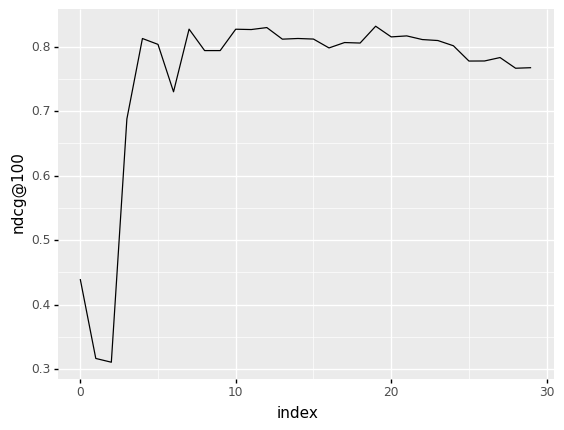

<ggplot: (986205245)>

In [51]:
# Show the eval metric in tabular format.

import pandas as pd
from plotnine import *
res["eval"]["index"] = list(range(0, len(res["eval"]["ndcg@100"])))
eval_df = pd.DataFrame(res["eval"])
print(eval_df.head())

(
   ggplot(eval_df, aes("index", "ndcg@100"))
   + geom_line()
)

## 평가 측도
* 질의별로 있는 문서에 대해서 predScore 기준으로 정렬 -> grade가 바뀌는?

,predScore
count,2342.000000
mean,1.615694
std,3.946453
min,-3.770548
25%,-2.544758
50%,4.060272
75%,5.606299
max,5.781308


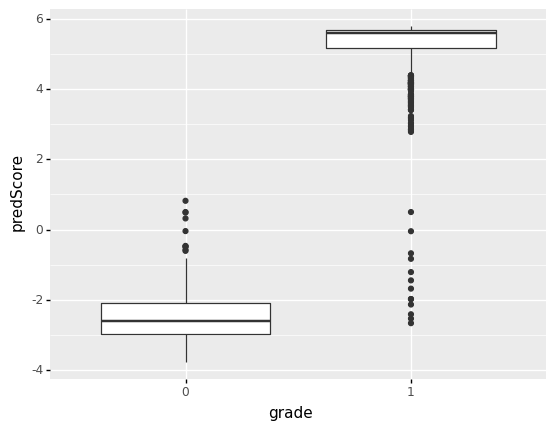

In [11]:
# make prediction
preds = ltr_model.predict(dtest)
len(preds), len(test_rdf[["grade"]])

pred_df = pd.DataFrame({"predScore": preds, "grade": test_rdf["grade"].values.tolist()})
pred_df["grade"] = pred_df["grade"].astype(str)

from plotnine import *

(
    ggplot(pred_df, aes("grade", "predScore"))
    + geom_boxplot()
).draw()

pred_df.describe()

## Inspect LTR Model

Looking at the model as a dataframe can tell you which splits helped the most

In [29]:
ltr_model.trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,features11,0.045961,0-1,0-2,0-1,5574.544430,236730.000000,NaN
1,0,1,0-1,features28,0.895880,0-3,0-4,0-3,2620.909180,223858.500000,NaN
2,0,2,0-2,features19,0.045833,0-5,0-6,0-5,77.000977,12871.500000,NaN
3,0,3,0-3,features0,0.318984,0-7,0-8,0-7,727.527344,80586.000000,NaN
4,0,4,0-4,features1,0.269079,0-9,0-10,0-9,1525.928220,143272.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5509,49,112,49-112,Leaf,NaN,NaN,NaN,NaN,0.083255,3.494480,NaN
5510,49,113,49-113,Leaf,NaN,NaN,NaN,NaN,0.023878,971.816284,NaN
5511,49,114,49-114,Leaf,NaN,NaN,NaN,NaN,0.133947,35.322144,NaN
5512,49,115,49-115,Leaf,NaN,NaN,NaN,NaN,0.151588,63.308674,NaN


아래 트리 그림을 보면 click_keywords.bm25 피쳐가 가장 처음으로 분기되는 기준임을 알 수 있다. 클릭을 많이 받은 문서가 높은 점수를 받았으니 당연한건가

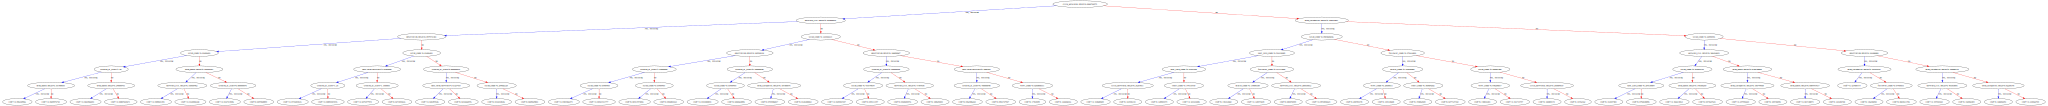

In [31]:
# xgb.plot_tree(ltr_model, num_trees=3)
xgb.to_graphviz(ltr_model, fmap=FEATURE_MAP_PATH, num_trees=3)

### Feature Importance
* Loss를 줄이는데 기여도가 가장 큰 순서대로

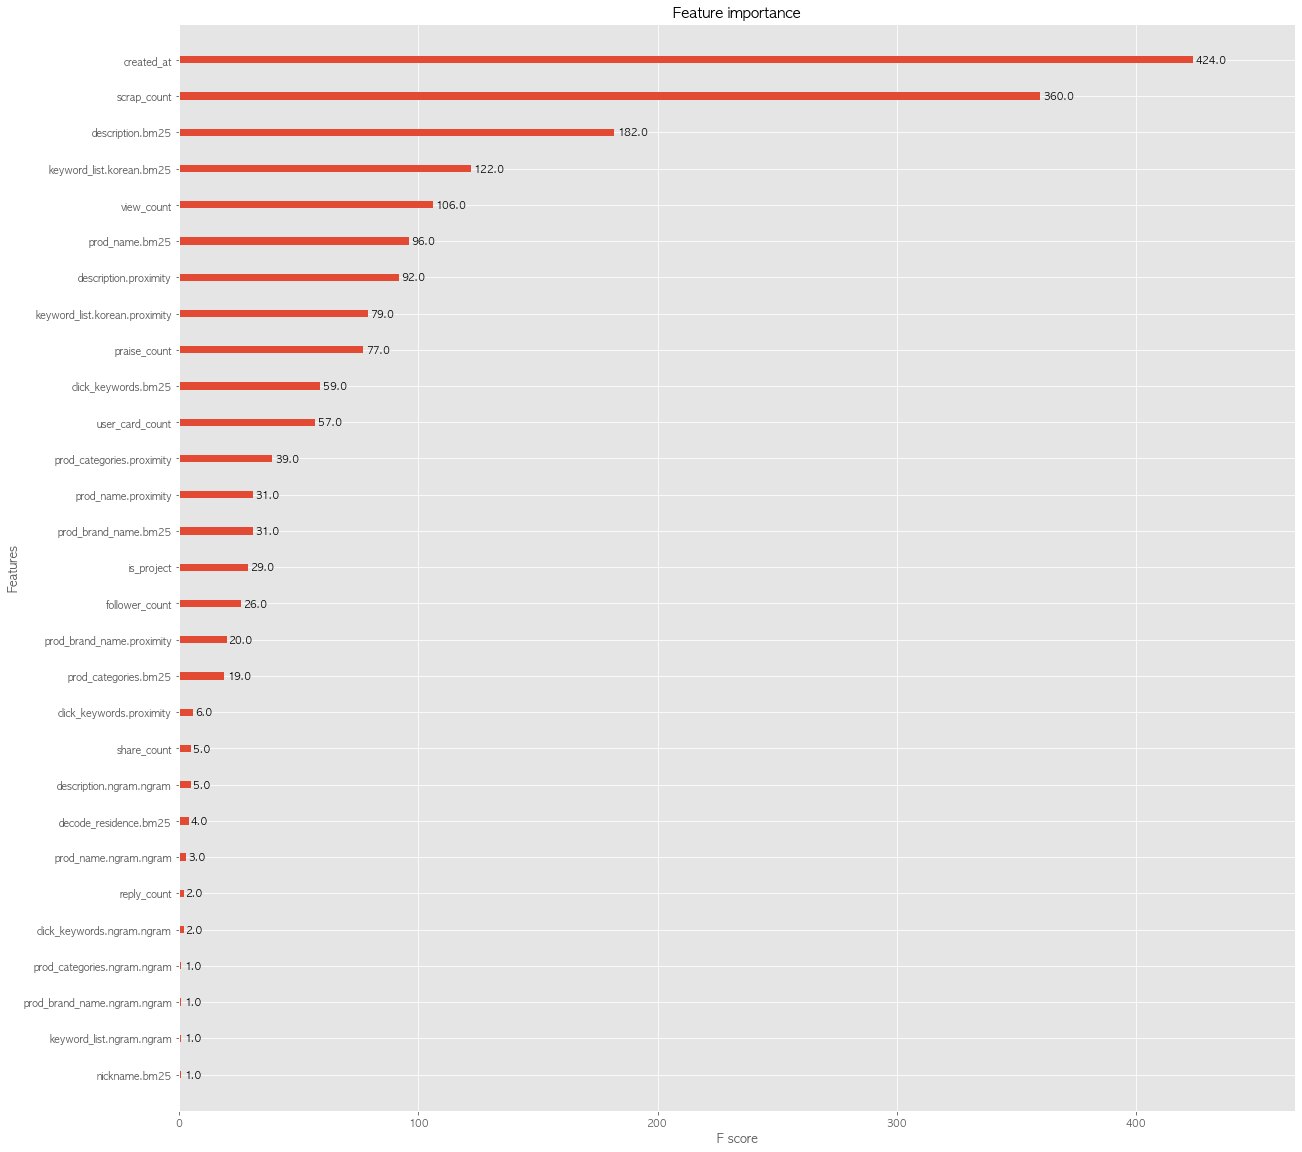

In [52]:
# this value is come frome `ltr_model.get_fscore()`
ax = xgb.plot_importance(ltr_model, fmap=FEATURE_MAP_PATH)
fig = ax.figure
fig.set_size_inches(20, 20)

### Uploading an XGBoost model to the plugin

Since the model can be represented with JSON, the plugin can parse it. But we need to make sure the plugin gets the proper feature value names in order for it to parse properly.

These are supplied via a mapping `txt` file, `fmap.txt`.

The first step is to dump the model with the feature mapping to the features already stored in the plugin.

In [55]:
# FEATURESET = "card.featureset.v2"
FEATURESET = "card.featureset.v3"
INDEX = "ThisIsUnused"           # 사실상 사용되지는 않고 있음(피쳐셋 경로를 사용)
RANKING_MODEL = "lambdamart"
MODEL_NAME = f"xgb-{RANKING_MODEL}-{DATA_CREATED_AT}.{RANKING_DATA}-{FEATURESET}"
MODEL_NAME

'xgb-lambdamart-20220504.card.click.ranking.3m.features.grade.binary.txt-card.featureset.v3'

In [56]:
import json
import ltr.client as client

client = client.ElasticClient()

model_dump = ltr_model.get_dump(fmap=FEATURE_MAP_PATH, dump_format='json')

# Manipulate the XGBoost output format to clean it up for posting to the plugin.
clean_model = [json.loads(line) for line in model_dump]

# Post it to the plugin
client.submit_xgboost_model(FEATURESET, INDEX, MODEL_NAME, clean_model)

URL Path: https://search-es2.stage.datahou.se/_ltr/_featureset/card.featureset.v3/_createmodel
Delete model xgb-lambdamart-20220504.card.click.ranking.3m.features.grade.binary.txt-card.featureset.v3: 404
Created Model xgb-lambdamart-20220504.card.click.ranking.3m.features.grade.binary.txt-card.featureset.v3 [Status: 201]


In [13]:
clean_model

[{'nodeid': 0,
  'depth': 0,
  'split': 'keyword_list.korean.bm25',
  'split_condition': 0.100097001,
  'yes': 1,
  'no': 2,
  'missing': 1,
  'children': [{'nodeid': 1,
    'depth': 1,
    'split': 'prod_name.bm25',
    'split_condition': 0.100043021,
    'yes': 3,
    'no': 4,
    'missing': 3,
    'children': [{'nodeid': 3,
      'depth': 2,
      'split': 'description.bm25',
      'split_condition': 0.100150451,
      'yes': 5,
      'no': 6,
      'missing': 5,
      'children': [{'nodeid': 5,
        'depth': 3,
        'split': 'prod_categories.bm25',
        'split_condition': 0.102172405,
        'yes': 7,
        'no': 8,
        'missing': 7,
        'children': [{'nodeid': 7,
          'depth': 4,
          'split': 'click_keywords.bm25',
          'split_condition': 0.0621301234,
          'yes': 9,
          'no': 10,
          'missing': 9,
          'children': [{'nodeid': 9, 'leaf': -0.0932474807},
           {'nodeid': 10, 'leaf': 0.0551724136}]},
         {'nodeid': 

### Confirm it works

In [ ]:
from ltr.release_date_plot import search
search(client, 'batman', 'xgb')

/Users/junhyeok.kim/.pyenv/versions/3.9.6/envs/hello-ltr/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning:

Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.



[{'id': '2661',
  'title': 'Batman',
  'overview': 'The Dynamic Duo faces four super-villains who plan to hold the world for ransom with the help of a secret invention that instantly dehydrates people.',
  'tagline': "He's Here Big As Life In A Real Bat-Epic",
  'directors': ['Leslie H. Martinson'],
  'cast': 'Adam West Burt Ward Lee Meriwether Cesar Romero Burgess Meredith Frank Gorshin Alan Napier Neil Hamilton Stafford Repp Madge Blake Reginald Denny Milton Frome Gil Perkins Dick Crockett George Sawaya Van Williams Jack LaLanne Arthur Tovey',
  'genres': ['Family', 'Adventure', 'Comedy', 'Science Fiction', 'Crime'],
  'release_date': '1966-07-30',
  'release_year': '1966',
  'poster_path': 'https://image.tmdb.org/t/p/w185/udDVJXtAFsQ8DimrXkVFqy4DGEQ.jpg',
  'vote_average': 6.0,
  'vote_count': 153,
  'score': 2.5180912},
 {'id': '93560',
  'title': 'Batman and Robin',
  'overview': 'This 15-chapter serial pits Batman and Robin against The Wizard, who uses a device that allows him to

### Compare it to the classic Ranklib model

In [ ]:
from ltr.release_date_plot import plot
plot(client, "batman", models = ['classic', 'xgb'])